Before reading the notebook, please make sure that you have installed numpy, matplotlib on your environment.

My first step to find the best fit was to plot the original points. I firstly define a datatype 'D' and use numpy to load the data from the txt document.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
##load data
RVtype = np.dtype({
    'names':['date', 'rv', 'e'],
    'formats':['i','f', 'f']})
D = np.loadtxt('data.txt', dtype=RVtype)
N = len(D)    #samples
D["date"] = D["date"]-2450681.527700

From above we know that the keys 'date','rv','e' respectively refer to the Julian Date, the mean radial velocity, the error.
Then I intentionally set the original date to be 0.
Run the codes below to see the figure.

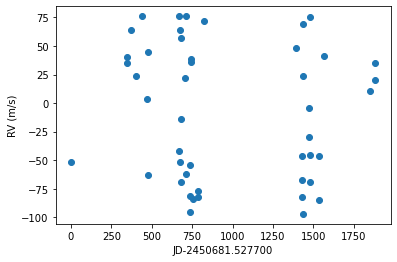

In [54]:
import matplotlib.pyplot as plt
plt.scatter(D["date"],D["rv"])
plt.xlabel('JD-2450681.527700')
plt.ylabel('RV (m/s)')
plt.savefig('OriginalData.png')
plt.show()

There are few things to highlight in the figure:

    1.There are large gaps between observations, which means the data we obtained aren't easy to determine its amplitude and period through naked eyes.

    2.However, it's still reasonable to guess the period to be very small or as large as 250 days.

    3.The amplitude is somehow much easier to guess, for the largest RV=80 m/s and the lowest to be -100 m/s. So the amplitude should be above 80 m/s.

    4.The intervals between each observations is randomly distributed, which makes it tricky to do FFT in search of the main frequency (we can still use FFT by data augmentation, but it should be considered in our lowest priority). However we can still use the Lomb Method to obtain the spectrum thus having a glimpse into the frequency domain.

So my next step was to determine the period, or, at least find the acceptable range for period. Following the literature's idea, I run the code to check the frequency domain:

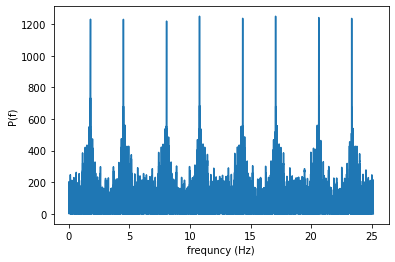

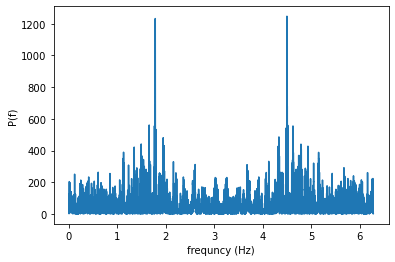

In [55]:
def LombPeriodogram(D,omega):
    su,sl = 0,0
    for i in range(N):
        su += np.sin( 2*omega*D["date"][i] )
        sl += np.cos( 2*omega*D["date"][i] )
    tangent_2omegatau = su / sl
    tau = np.arctan(tangent_2omegatau)
    scu,scl,ssu,ssl = 0,0,0,0
    h_bar = np.average(D["rv"])
    sigma_sqr = np.std(D["rv"])
    P_N = 0
    for i in range(N):
        scu += ( (D["rv"][i]-h_bar)*np.cos(omega*(D["date"][i]-tau)) )
        scl += np.square( np.cos(omega*(D["date"][i]-tau)) )
        ssu += ( (D["rv"][i]-h_bar)*np.sin(omega*(D["date"][i]-tau)) )
        ssl += np.square( np.sin(omega*(D["date"][i]-tau)) )
    P_N = ( np.square(scu)/ scl + np.square(ssu)/ ssl )/(2*sigma_sqr)
    return P_N
##fig1
f = np.linspace(0.0001,4,100000)
x = f*2*np.pi
y = LombPeriodogram(D,x)
plt.plot(x,y)
plt.xlabel('frequncy (Hz)')
plt.ylabel('P(f)')
plt.savefig('Spectrum1.png')
plt.show()
##fig2
f = np.linspace(0.0001,1,100000)
x = f*2*np.pi
y = LombPeriodogram(D,x)
plt.plot(x,y)
plt.xlabel('frequncy (Hz)')
plt.ylabel('P(f)')
plt.savefig('Spectrum2.png')
plt.show()

The frequency domain shows no evidence of a long period, thus searching for a short period fit becomes our first priority.
The first approach was to fit the data with non-linear chi^2 minimization method, the Gradient Descent Method was the most fundatmental one.
Setting the initial parameters to be (60,60,-5,3)

[[ 2.48988167e+01  7.40714255e+00 -1.77988065e+01  2.06163025e+06]] 1426.2208982663108


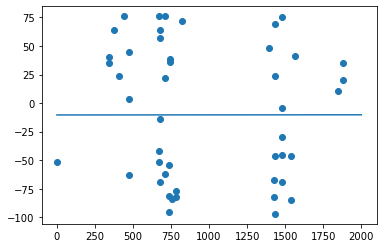

In [56]:
alpha=.4
delta_theta = np.array([[.0001,0,0,0],[0,.0001,0,0],[0,0,0.0001,0],[0,0,0,.001]])
##RV function
def f(t,params):
    params = params.reshape(1,-1)
    phi = 2*t*np.pi/params[0][3]
    return params[0][2] + params[0][0]*np.sin(phi) + params[0][1]*np.cos(phi)
##matrix operator
def dot(A,B):
    A=A.reshape(1,-1)
    rA = A.shape[0]
    cA = A.shape[1]
    cB = B.shape[1]
    sum = np.zeros((rA,cB))
    for j in range(cA):
        for i in range(rA):
            for k in range(cB):
                sum[i][k] += A[i][j] * B[j][k]
    return sum
##gradient descent
def grad(theta,S):
    diff = (f(S["date"],theta) - S["rv"])/S["e"]
    diff = diff.reshape((1,N))
    grad_f = np.zeros((N,theta.shape[0]))
    for i in range(N):
        for j in range(theta.shape[0]):
            grad_f[i][j] = (f(S["date"][i],theta+delta_theta[j])-f(S["date"][i],theta)) / delta_theta[j][j]
    return dot(diff,grad_f)
def gradient_descent(theta,S):
    local_gradient = grad(theta,S)
    while not np.all(np.abs(local_gradient) <= 1e-5):
        theta = theta - alpha * local_gradient
        local_gradient = grad(theta,S)
    return theta
def chi_square(theta,S):
    chi_sqr = 0
    for i in range(N):
        chi_sqr += np.square( ( f(S["date"][i],theta) - S["rv"][i] ) / S["e"][i] )
    return chi_sqr
##fit
p0 = np.array([60,60,-5,3])
pf = gradient_descent(p0,D)
print(pf,chi_square(pf,D))
plt.scatter(D["date"],D["rv"])
x=np.linspace(0,2000,10000)
plt.plot(x,f(x,pf))
plt.savefig('PoorFit.png')
plt.show()

The result was hardly acceptable. By changing the study rate alpha, we may get a better result but still far below our expectation.
Then I try to optimize it with the Levenberg-Marquardt Method but the result was still disappointing.

The next approach was to first determine the period by simply enumerating. Since the period was first set to one specific value, the RV relation shows linearity.
    I.e, RV = A cos() + B sin() + C
If we first process the input data, turning into a 2D sample feature:
    X[i][0] = cos(input)
    X[i][1] = sin(input)
Then we put the processed samples into the linear model to determine the rest parameters A,B and C.

In [58]:
import time
##frequency select
def Sample_Produce(P,S):
    X = np.append( np.cos(np.pi*2*S["date"]/P) , np.sin(np.pi*2*S["date"]/P) )
    X = X.reshape(2,-1).T
    return X

##function
def f(X_sample,params):
    params = params.reshape(1,-1)
    return params[0][2] + params[0][0]*X_sample[0] + params[0][1]*X_sample[1]

##matrix operator
def dot(A,B):
    #A=A.reshape(1,-1)
    rA = A.shape[0]
    cA = B.shape[0]
    cB = B.shape[1]
    sum = np.zeros((rA,cB))
    for j in range(cA):
        for i in range(rA):
            for k in range(cB):
                sum[i][k] += A[i][j] * B[j][k]
    return sum
##solve linear equation for theta+
def solve(A,B):
    A_inv = np.linalg.inv(A)
    x = np.matmul(A_inv,B)
    return x
##gradient
def grad(theta,X):
    theta = theta.reshape(1,-1)
    grad_f = np.zeros((N,theta.shape[1]))
    for i in range(N):
        grad_f[i][0] = X[i][0]
        grad_f[i][1] = X[i][1]
        grad_f[i][2] = 1
    return grad_f
##Hessian
def hess(theta,X,error):
    theta = theta.reshape(1,-1)
    G = grad(theta,X)
    H = np.zeros((theta.shape[1],theta.shape[1]))
    for i in range(N):
        for j in range(theta.shape[1]):
            for k in range(theta.shape[1]):
                H[j][k] = G[i][j]*G[i][k] / np.square(error[i])
    return H
##first order derivative of chi_square
def chi_derivative(theta,X,y,error):
    diff = np.zeros((1,N))
    for i in range(N):
        diff[0][i] = (f(X[i],theta) - y[i]) / np.square(error[i])
    theta = theta.reshape(1,-1)
    grad_f = grad(theta,X)
    return np.matmul( diff , grad_f )
##chi_square
def chi_square(theta,X,y,error):
    chi_sqr = 0
    for i in range(N):
        chi_sqr += np.square( ( f(X[i],theta) - y[i] ) / error[i] )
    return chi_sqr
##Levenberg-Marquardt Method
def Mrq(theta,X,y,error):
    start=time.time()
    check=start
    chi_sqr0 = chi_square(theta,X,y,error)
    l = .01
    while (check-start<.2):  #pause criteria
        B = -chi_derivative(theta,X,y,error)
        A = hess(theta,X,error)
        for i in range(A.shape[0]):
            A[i][i] = A[i][i] * (1+l)
        theta_1 = theta + solve( A , B.T ).T
        chi_sqr1 = chi_square(theta_1,X,y,error)
        if (chi_sqr1 >= chi_sqr0):
            l = l * 10
        else:
            l = l / 10
            theta = theta_1 
            chi_sqr0 = chi_sqr1 
        check=time.time()
    return theta


I import 'time' for the abortion criterion, because the longer time our code runs the better result it gains while the total runtime can be restricted by the criterion.
Try running the code below to get the result. Since the time limit was 0.2s per loop, the total runtime should be about 80 seconds if we run 400 different Periods.

[[ 60.92721853  43.0192967  -10.3124773 ]] 207.77504791993357


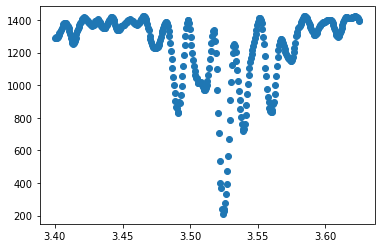

0

In [59]:
def main():
    P=3.52427417
    X = Sample_Produce( P,D )
    y = D["rv"]
    err = D["e"]
    params = np.array([1,2,3])
    params = Mrq(params,X,y,err)
    print(params,chi_square(params,X,y,err))
    Pr = np.linspace(3.4,3.625,400)
    pt = np.zeros( len(Pr) )
    for i in range( len(Pr) ):
        X = Sample_Produce( Pr[i] , D )
        params = Mrq(params,X,y,err)
        pt[i] = chi_square(params,X,y,err)
    plt.scatter(Pr,pt)
    plt.savefig('P_Enumerate.png')
    plt.show()
    return 0

main()

The figure shows the chi^2 result from different Periods. I've also run simulations at large Periods, but the result was as high as 1400, far away from the global minimum. As we can see, the large numbers of local minimum can be annoying if we directly run the gradient descent code, providing a great explaination for the previous failed trials. Meanwhile the global minimum can be easily found. However, it's impossible to get the best fit period by simply enumerating. The final step was to put these parameters into the LM code to eventually determines the best fit parameters.

In [60]:
##function
def f(t,params):
    params = params.reshape(1,-1)
    phi = 2*t*np.pi/params[0][3]
    return params[0][2] + params[0][0]*np.sin(phi) + params[0][1]*np.cos(phi)

##matrix operator
def dot(A,B):
    #A=A.reshape(1,-1)
    rA = A.shape[0]
    cA = B.shape[0]
    cB = B.shape[1]
    sum = np.zeros((rA,cB))
    for j in range(cA):
        for i in range(rA):
            for k in range(cB):
                sum[i][k] += A[i][j] * B[j][k]
    return sum
##solve linear equation for theta+
def solve(A,B):
    A_inv = np.linalg.inv(A)
    x = dot(A_inv,B)
    return x
##gradient
def grad(theta,S):
    theta = theta.reshape(1,-1)
    grad_f = np.zeros((N,theta.shape[1]))
    for i in range(N):
        t = S["date"][i]
        grad_f[i][0] = np.sin((2*np.pi*t)/theta[0][3])
        grad_f[i][1] = np.cos((2*np.pi*t)/theta[0][3])
        grad_f[i][2] = 1
        grad_f[i][3] = (-theta[0][0]*np.cos((2*np.pi*t)/theta[0][3]) + theta[0][1]*np.sin((2*np.pi*t)/theta[0][3])) * (2*np.pi*t) / np.square(theta[0][3])
    return grad_f
##Hessian
def hess(theta,S):
    theta = theta.reshape(1,-1)
    G = grad(theta,S)
    H = np.zeros((theta.shape[1],theta.shape[1]))
    for i in range(N):
        for j in range(theta.shape[1]):
            for k in range(theta.shape[1]):
                H[j][k] = G[i][j]*G[i][k] / np.square(S["e"][i])
    return H
##first order derivative of chi_square
def chi_derivative(theta,S):
    diff = (f(S["date"],theta) - S["rv"]) / np.square(S["e"])
    diff = diff.reshape((1,N))
    theta = theta.reshape(1,-1)
    grad_f = grad(theta,S)
    return dot(diff,grad_f)
##chi_square
def chi_square(theta,S):
    chi_sqr = 0
    for i in range(N):
        chi_sqr += np.square( ( f(S["date"][i],theta) - S["rv"][i] ) / S["e"][i] )
    return chi_sqr
##Levenberg-Marquardt Method
def Mrq(theta,S,lim):
    start=time.time()
    check=start
    chi_sqr0 = chi_square(theta,S)
    l = .00001
    while (chi_sqr0 >= lim)&(check-start<10):  #pause criteria
        B = -chi_derivative(theta,S)
        A = hess(theta,S)
        #A = dot(B.T,B)
        for i in range(A.shape[0]):
            A[i][i] = A[i][i] * (1+l)
        theta_1 = theta + solve( A , B.T ).T
        chi_sqr1 = chi_square(theta_1,S)
        if (chi_sqr1 >= chi_sqr0):
            l = l * 10
        else:
            l = l / 10
            theta = theta_1 
            chi_sqr0 = chi_sqr1 
        #print(theta,chi_sqr0)
        check=time.time()
    return theta

##fit
par = np.array([ 43.28144963,61.0055289,  -10.28913117  , 3.52427464])
par = Mrq( par , D , 200)
print(par,chi_square(par,D))


/var/folders/9r/d810_63d7yx101gkrv_41ygm0000gn/T/ipykernel_87179/2297416651.py:69: RuntimeWarning: overflow encountered in double_scalars
  A[i][i] = A[i][i] * (1+l)


[[ 43.28144626  61.00551206 -10.28913155   3.52427464]] 207.75878493385156


The overflow error was inevitable because we are very close to the global minimum, we can solve the problem by repeatedly substitute the initial parameters to the best fit parameters.

By doing so, we finally obtain the best fit parameters:
[ 43.28144626  61.00551206 -10.28913155   3.52427464] 
with chi^2=207.75878493385156
where the elements in the array are the coefficient of cosine, the coefficient of sine, the mean RV, period respectively.
To visualize the result, please run the code below, noting that we ignored some segregated data points to show the details

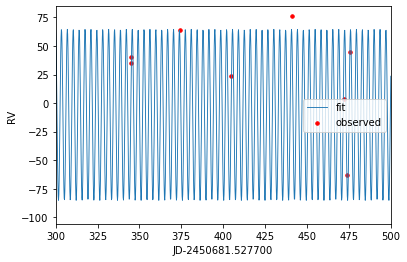

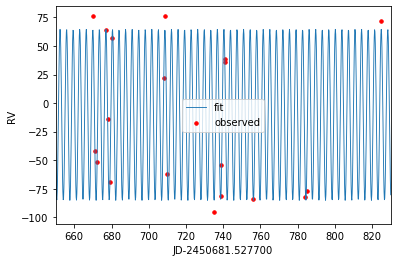

In [61]:
#fig1
plt.xlim(300,500)
plt.scatter( D["date"] , D["rv"] ,c="r",label='observed',s=12)
x = np.linspace(0,D["date"].max(),10000)
plt.xlabel('JD-2450681.527700')
plt.ylabel('RV')
plt.plot(x,f(x,par),linewidth=0.9,label='fit')
plt.legend()
plt.savefig('BestFit1.png')
plt.show()
#fig2
plt.xlim(650,830)
plt.scatter( D["date"] , D["rv"] ,c="r",label='observed',s=12)
x = np.linspace(0,D["date"].max(),10000)
plt.xlabel('JD-2450681.527700')
plt.ylabel('RV')
plt.plot(x,f(x,par),linewidth=0.9,label='fit')
plt.savefig('BestFit2.png')
plt.legend()

To visulize error, it's intuitive to characterize the residuals.

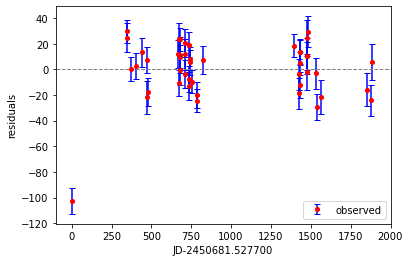

In [63]:
oc = D["rv"] - f(D["date"],par)
plt.errorbar(D["date"],oc,yerr=D["e"],fmt='o',color='r',ecolor='b',capsize=3,ms=4,label='observed')
plt.xlabel('JD-2450681.527700')
plt.ylabel('residuals')
plt.xlim(-100,2000)
Dp = np.linspace(-100,2000,1000)
plt.plot(Dp,Dp*0,linewidth=1,c='grey',linestyle='--')
plt.legend()
plt.savefig('Residuals1.png')
plt.show()

If we abandon the first datum for no reason, the result would be acceptable and can discover little evidence of the center of mass acceleration. This indicates little possibility of surrounding planets or stars.

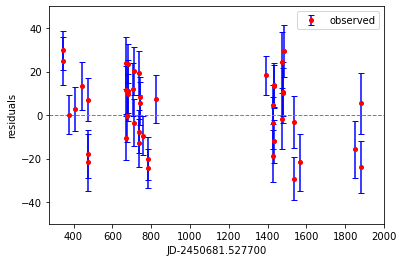

In [64]:
plt.errorbar(D["date"],oc,yerr=D["e"],fmt='o',color='r',ecolor='b',capsize=3,ms=4,label='observed')
plt.xlabel('JD-2450681.527700')
plt.ylabel('residuals')
plt.xlim(275,2000)
plt.ylim(-50,50)
Dp = np.linspace(275,2000,1000)
plt.plot(Dp,Dp*0,linewidth=1,c='grey',linestyle='--')
plt.legend()
plt.savefig('Residuals2.png')
plt.show()

It's hard to Use Jupyter Notebook to do astrophysical anaylsis.
This part will be shown in the PDF below.